In [41]:
import numpy as np
import pylab as plt
from hera_sim.antpos import linear_array
from hera_filters import dspec

from hera_cal import nucal, datacontainer, apply_cal
from jax import numpy as jnp
import jax
jax.config.update("jax_enable_x64", True)

%matplotlib notebook

In [102]:
nfreqs = 1500
nants = 20
npix = 300
freqs = np.linspace(50e6, 250e6, nfreqs)
sky = np.random.uniform(0, 10, size=(1, npix)) * (freqs[:, None] / 150e6) ** -0.75
l = np.linspace(-1, 1, npix)
beam = np.sinc(l[:, None] / np.sin(0.25 * 150e6 / freqs[None, :]))
s_hat = np.array([l])

antpos = linear_array(nants, sep=5)

bls = []
scale = 1
for ai in antpos:
    for aj in antpos:
        if aj != ai and aj > ai:
            bls.append((antpos[aj] - antpos[ai]) * scale)
            
bls = np.array(bls)[:, 0][:, None]


dx = np.diff(l)[0]
u = (freqs * bls / 2.998e8)

top = np.argsort(sky[0])[30:]

fringe1 = np.exp(-2 * np.pi * 1j * u[:, :, None] * (l[None, None, :] + dx / 2))
fringe2 = np.exp(-2 * np.pi * 1j * u[:, :, None] * (l[None, None, :] - dx / 2))
fringe = 1./(-2j * np.pi * u[..., None]) * (fringe1 - fringe2) / dx
V_sky = np.sum(sky[None, :, :] * beam.T[None] * fringe, axis=-1)
V_sky_inc = np.sum(sky[None, :, top] * beam[top].T[None] * fringe[..., top], axis=-1)



In [103]:
ant_amp = np.random.uniform(0.5, 1.5, (len(antpos), nfreqs))
ant_phase = np.random.uniform(0, 2 * np.pi, (len(antpos), nfreqs))


In [104]:
vis_dict = {}
model_dict = {}
true_dict = {}
ci = 0
for ai in antpos:
    for aj in antpos:
        if aj != ai and aj > ai:
            g1 = ant_amp[ai] * np.exp(1j * ant_phase[ai])
            g2 = ant_amp[aj] * np.exp(1j * ant_phase[aj])
            vis_dict[(ai, aj)] = V_sky[ci] * g1 * g2.conj()
            vis_dict[(aj, ai)] = vis_dict[(ai, aj)].conj()
            model_dict[(ai, aj)] = V_sky_inc[ci]
            true_dict[(ai, aj)] = V_sky[ci]
            true_dict[(aj, ai)] = true_dict[(ai, aj)].conj()
            model_dict[(aj, ai)] = model_dict[(ai, aj)].conj()
            ci += 1
            
            


In [105]:
@jax.jit
def stefcal(data_matrix, model_matrix, wgts, tol=1e-10, maxiter=500, stepsize=0.5):
    """
    """
    def inner_function(args):
        """
        """
        g_temp, i, tau = args
        g_old = jnp.copy(g_temp)
        zg = g_temp[:, None] * model_matrix
        zgw = g_temp[:, None] * model_matrix * wgts
        g_temp = jnp.sum(jnp.conj(data_matrix) * zgw, axis=(0)) / jnp.sum(jnp.conj(zgw) * zg, axis=(0))
        g_temp = g_temp * stepsize + g_old * (1 - stepsize)
        tau = jnp.sqrt(jnp.sum(jnp.abs(g_temp - g_old) ** 2))/ jnp.sqrt(jnp.sum(jnp.abs(g_temp)**2))
        return g_temp, i + 1, tau
    
    def conditional_function(args):
        """
        """
        _, i, tau = args
        return (tau > tol) & (i < maxiter)
    
    nants = data_matrix.shape[0]
    gains = jnp.ones(nants, dtype=complex)
    
    return jax.lax.while_loop(conditional_function, inner_function, (gains, 0, 1))

def run_stefcal(data_matrix, model_matrix, wgts, tol=1e-10, maxiter=500, stepsize=0.5):
    """
    """
    gains = []
    niter = []
    for i in range(data_matrix.shape[-1]):
        g, i, tau = stefcal(data_matrix[..., i], model_matrix[..., i], wgts[..., i], tol=tol, maxiter=maxiter, stepsize=stepsize)
        gains.append(g)
        niter.append(i)
        
    return np.array(gains).T, np.array(niter).T

In [135]:
%%time
Nants = nants

data_matrix = np.zeros((nants, nants, nfreqs), dtype=complex)
model_matrix = np.zeros((nants, nants, nfreqs), dtype=complex)
true_model_matrix = np.zeros((nants, nants, nfreqs), dtype=complex)
wgts_array = np.ones_like(model_matrix).real

for n in range(Nants):
    for m in range(Nants):
        if n != m:
            if np.linalg.norm(antpos[m] - antpos[n]) < 70:
                data_matrix[m, n] = vis_dict[(m, n)]
                model_matrix[m, n] = model_dict[(m, n)]
                wgts_array[m, n] = 1
                true_model_matrix[m, n] = true_dict[(m, n)]

CPU times: user 15.6 ms, sys: 9.35 ms, total: 25 ms
Wall time: 22.8 ms


In [137]:
%%time
g, niter = run_stefcal(data_matrix, model_matrix, wgts_array, maxiter=1000, tol=1e-10, stepsize=0.5)
G = g[:, None, :] * g[None, ...].conj()
cal = data_matrix / G

CPU times: user 315 ms, sys: 5.14 ms, total: 320 ms
Wall time: 320 ms


In [138]:
import uvtools
def delay_spectra(x):
    """
    """
    return np.abs(uvtools.utils.FFT(x, taper='bh7'))

<IPython.core.display.Javascript object>


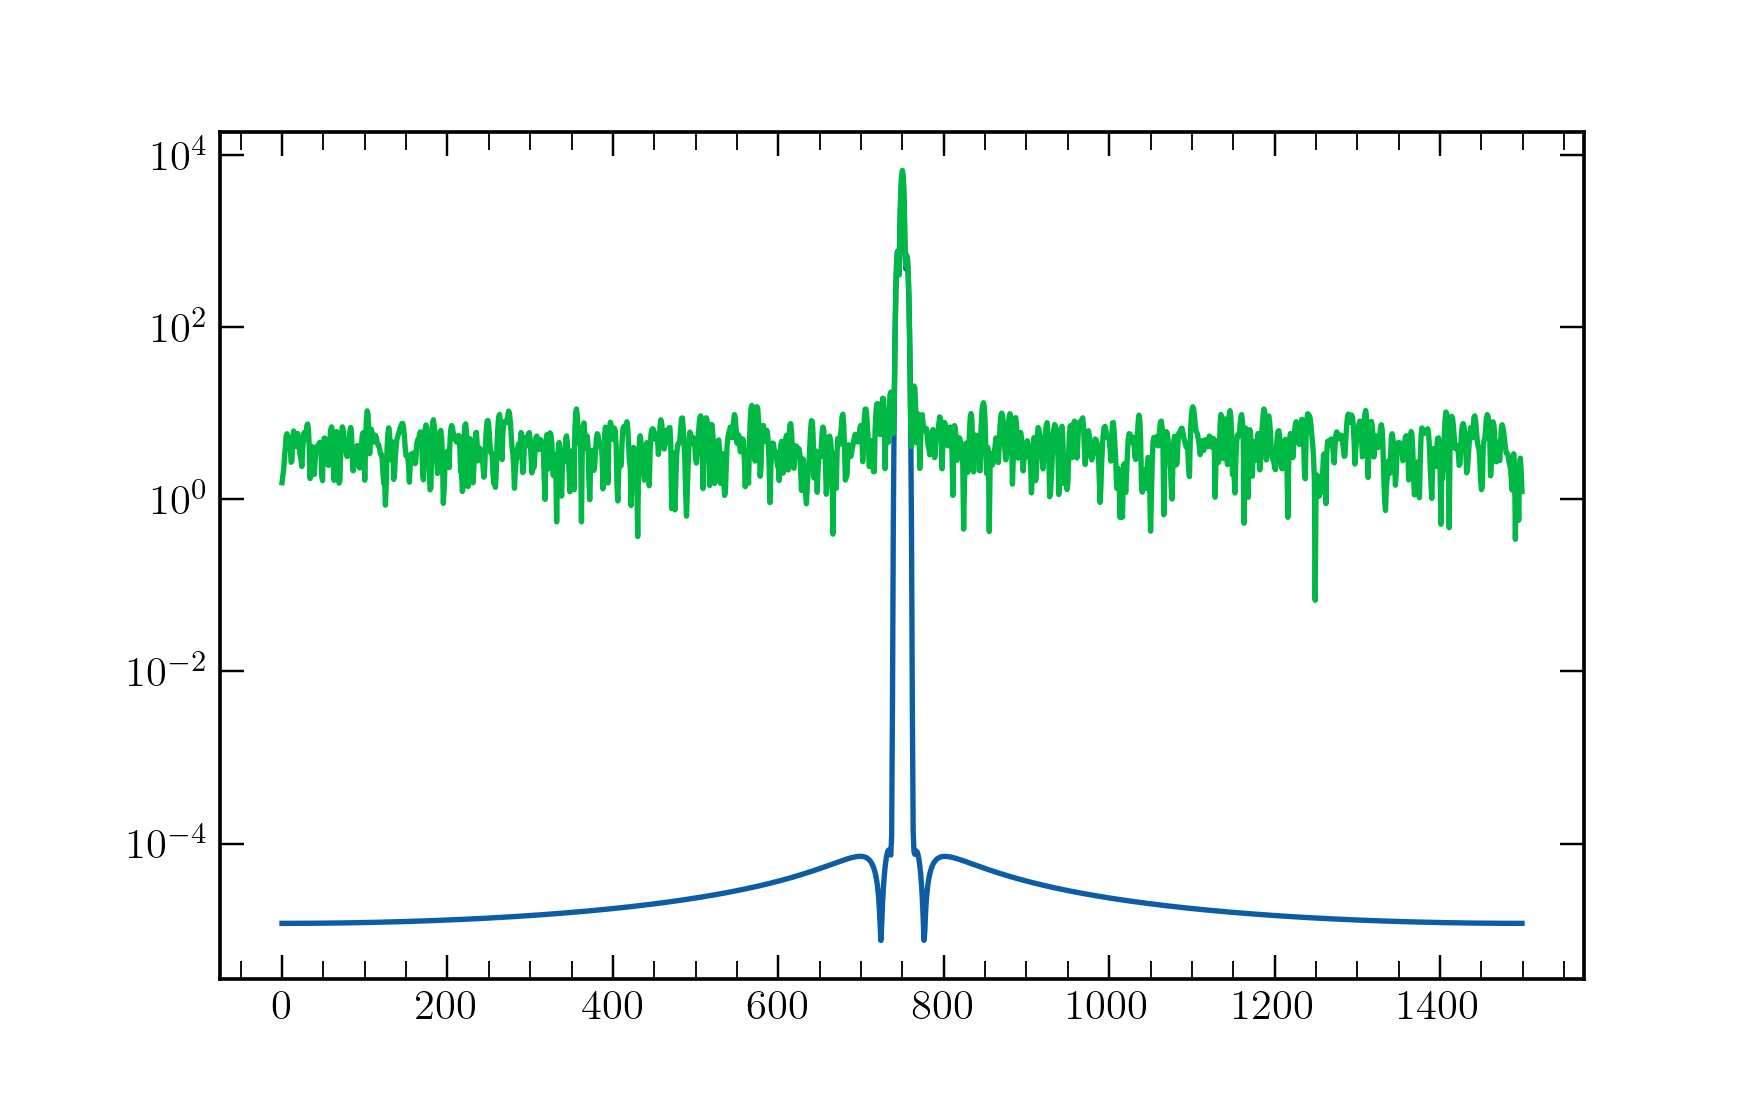

In [139]:
plt.figure()
plt.semilogy(delay_spectra(model_matrix[0, 1]))
plt.semilogy(delay_spectra(cal[0, 1]))
plt.show()

<IPython.core.display.Javascript object>


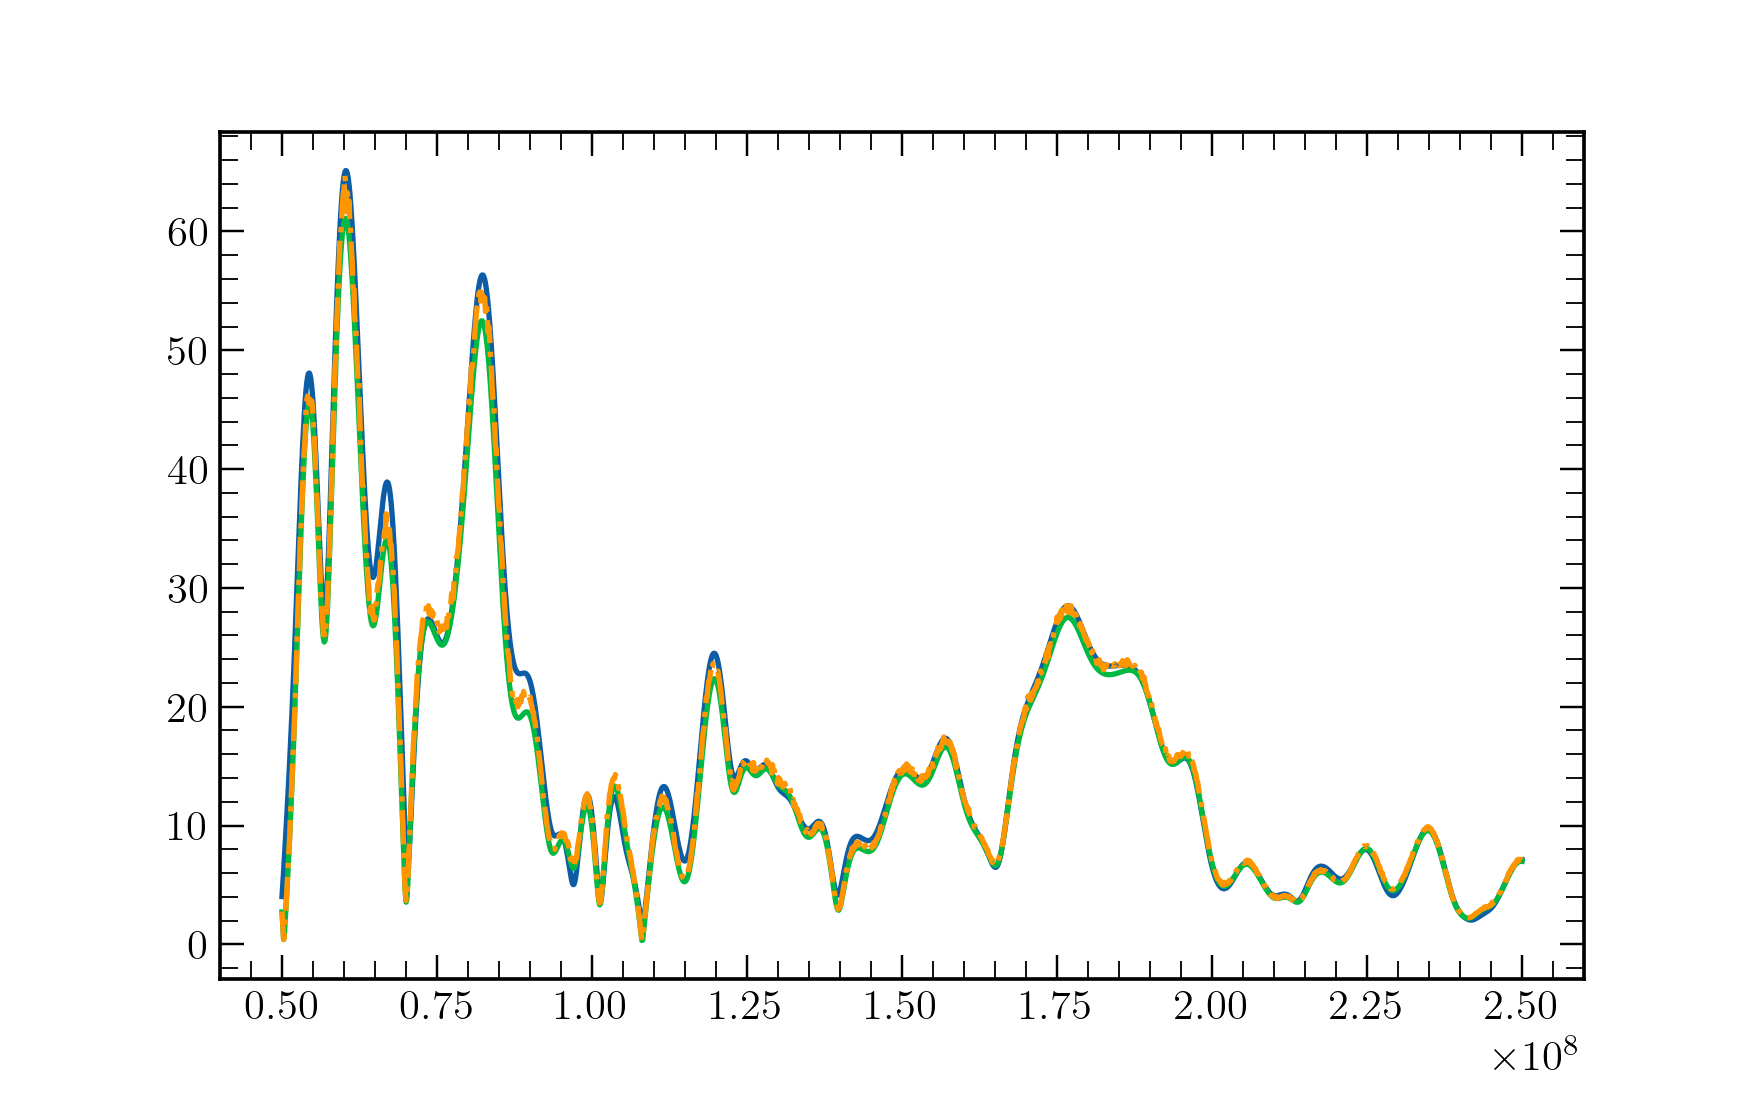

In [141]:
ant1, ant2 = 0, 9

plt.figure()
plt.plot(freqs, np.abs(model_matrix[ant1, ant2]), label='Data Model')
plt.plot(freqs, np.abs(true_model_matrix[ant1, ant2]), label='True Visibility')
plt.plot(freqs, np.abs(cal[ant1, ant2]), ls='-.', label='Calibrated Data')
plt.show()

<IPython.core.display.Javascript object>


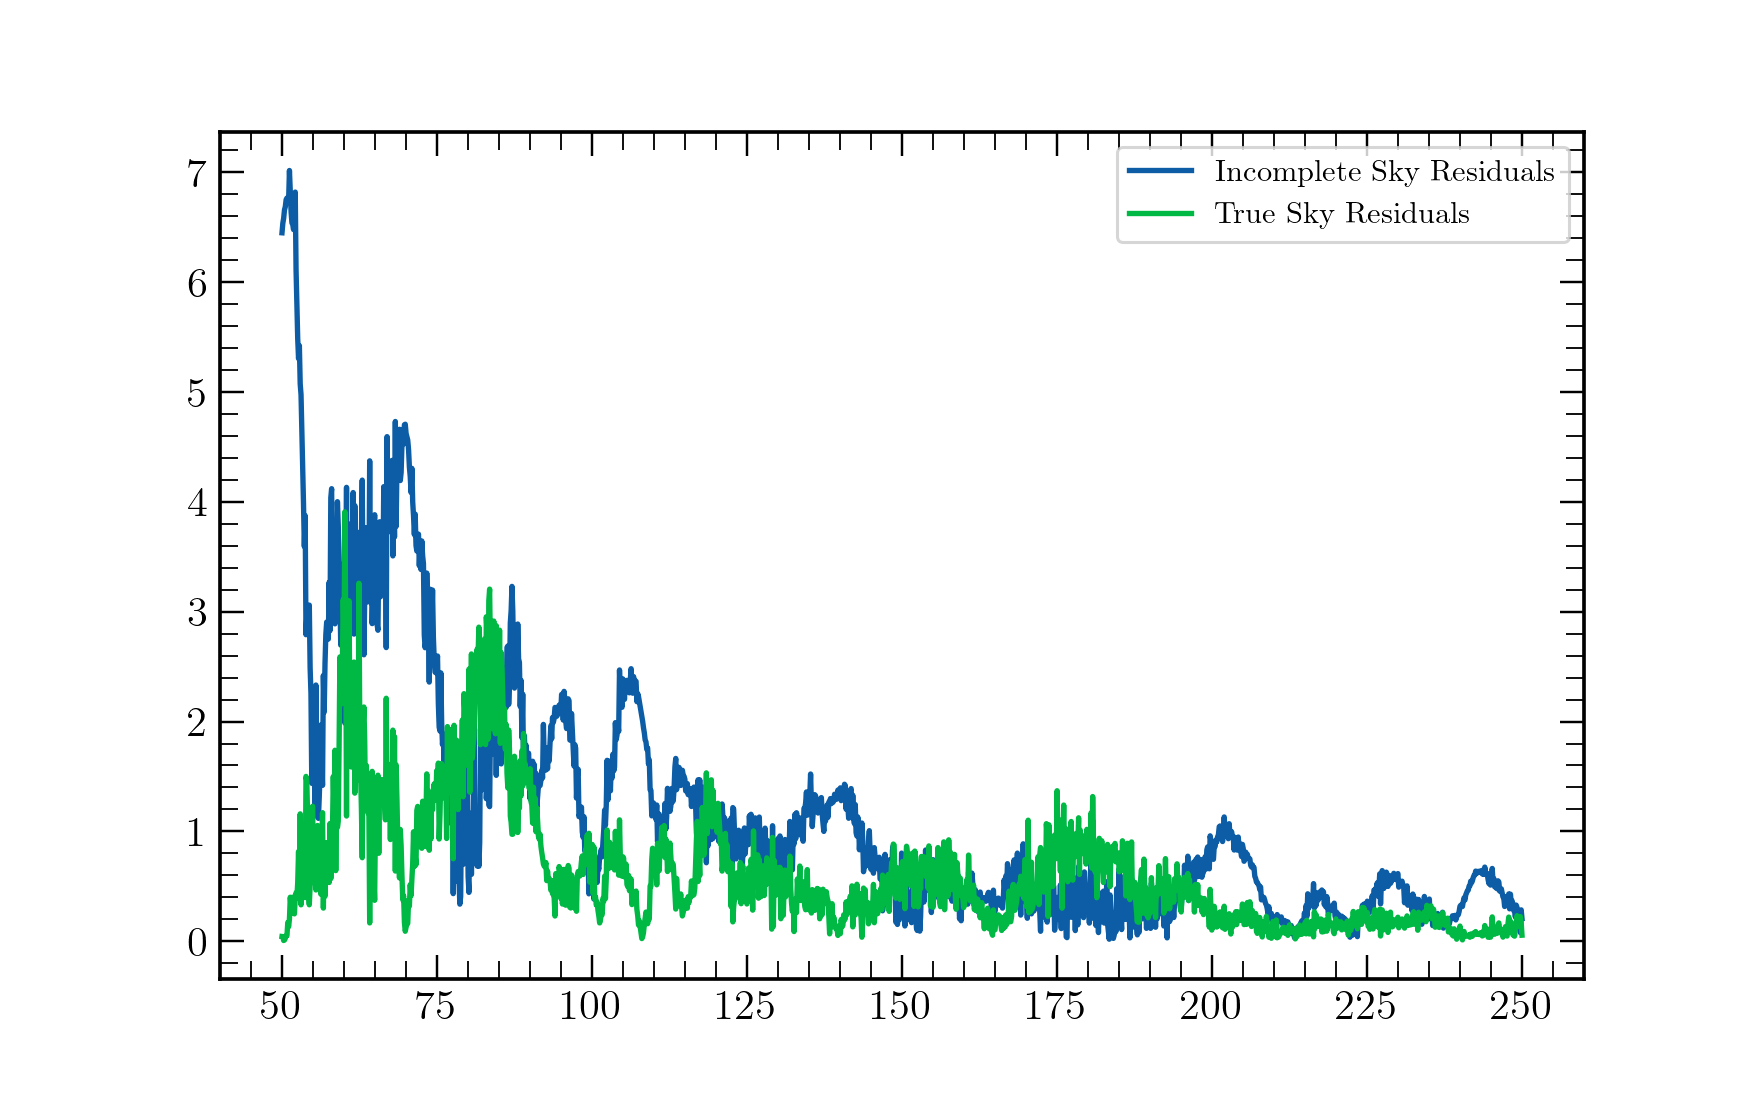

In [142]:
ant1, ant2 = 0, 9

plt.figure()
plt.plot(freqs / 1e6, np.abs(cal[ant1, ant2] - model_matrix[ant1, ant2]), label='Incomplete Sky Residuals')
plt.plot(freqs / 1e6, np.abs(cal[ant1, ant2] - true_model_matrix[ant1, ant2]), label='True Sky Residuals')
plt.legend()
plt.show()

## Fit Nucal Model to Calibrated Data

In [143]:
from hera_cal import nucal, datacontainer, apply_cal

In [144]:
gains = {(i, "Jnn"): g[i][None, :] for i in range(g.shape[0])}
dc = datacontainer.DataContainer({k + ('nn', ): np.copy(vis_dict[k])[None, :] for k in vis_dict})
wgts = {k: np.ones_like(dc[k]).real for k in dc}
apply_cal.calibrate_in_place(dc, gains)

In [145]:
radial_reds = nucal.RadialRedundancy(antpos)
spatial_filters = nucal.compute_spatial_filters(radial_reds, freqs)
spectral_filters = nucal.compute_spectral_filters(freqs, 30e-9)[0].real
nucal_model = nucal.fit_nucal_foreground_model(dc, wgts, radial_reds, spatial_filters, spectral_filters, tol=1e-12)

<IPython.core.display.Javascript object>


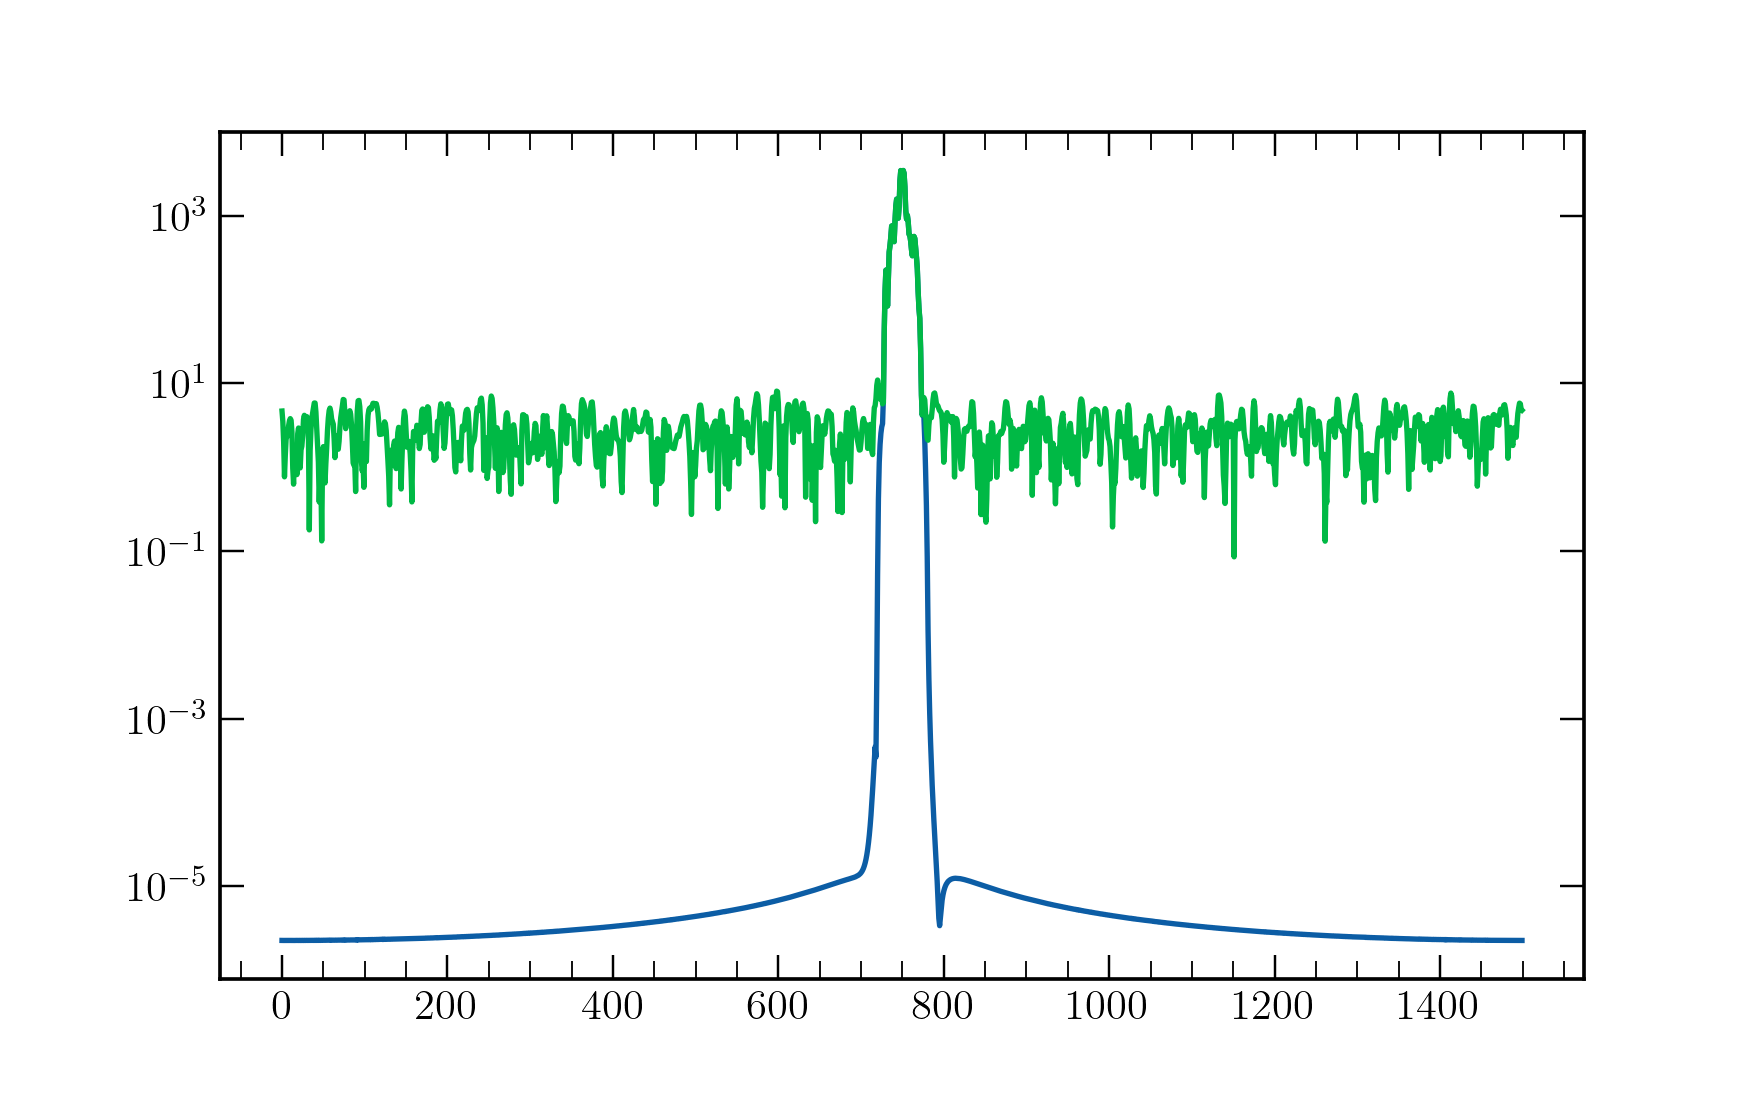

In [146]:
plt.figure()
plt.semilogy(delay_spectra(nucal_model[(0, 5, 'nn')][0]))
plt.semilogy(delay_spectra(dc[(0, 5, 'nn')][0]))

In [153]:
%%time
Nants = nants
fi = 0

data_matrix = np.zeros((nants, nants, nfreqs), dtype=complex)
nucal_model_matrix = np.zeros((nants, nants, nfreqs), dtype=complex)
true_model_matrix = np.zeros((nants, nants, nfreqs), dtype=complex)

nucal_model = datacontainer.DataContainer(nucal_model)
wgts_array = np.zeros_like(model_matrix).real
for n in range(Nants):
    for m in range(Nants):
        if n != m:
            if np.linalg.norm(antpos[m] - antpos[n]) < 70:
                data_matrix[m, n] = vis_dict[(m, n)]
                nucal_model_matrix[m, n] = nucal_model[radial_reds.get_redundant_group((m, n, 'nn'))[0]][0]
                true_model_matrix[m, n] = true_dict[(m, n)]
                wgts_array[m, n] = 1
                

CPU times: user 181 ms, sys: 9.27 ms, total: 190 ms
Wall time: 189 ms


In [154]:
%%time
gstef_new, niter = run_stefcal(data_matrix, nucal_model_matrix, wgts_array, maxiter=1000, tol=1e-15, stepsize=0.5)

CPU times: user 434 ms, sys: 2.56 ms, total: 436 ms
Wall time: 435 ms


In [155]:
Gfn = gstef_new[:, None, :] * gstef_new[None, ...].conj()
cal_fn = data_matrix / Gfn

<IPython.core.display.Javascript object>


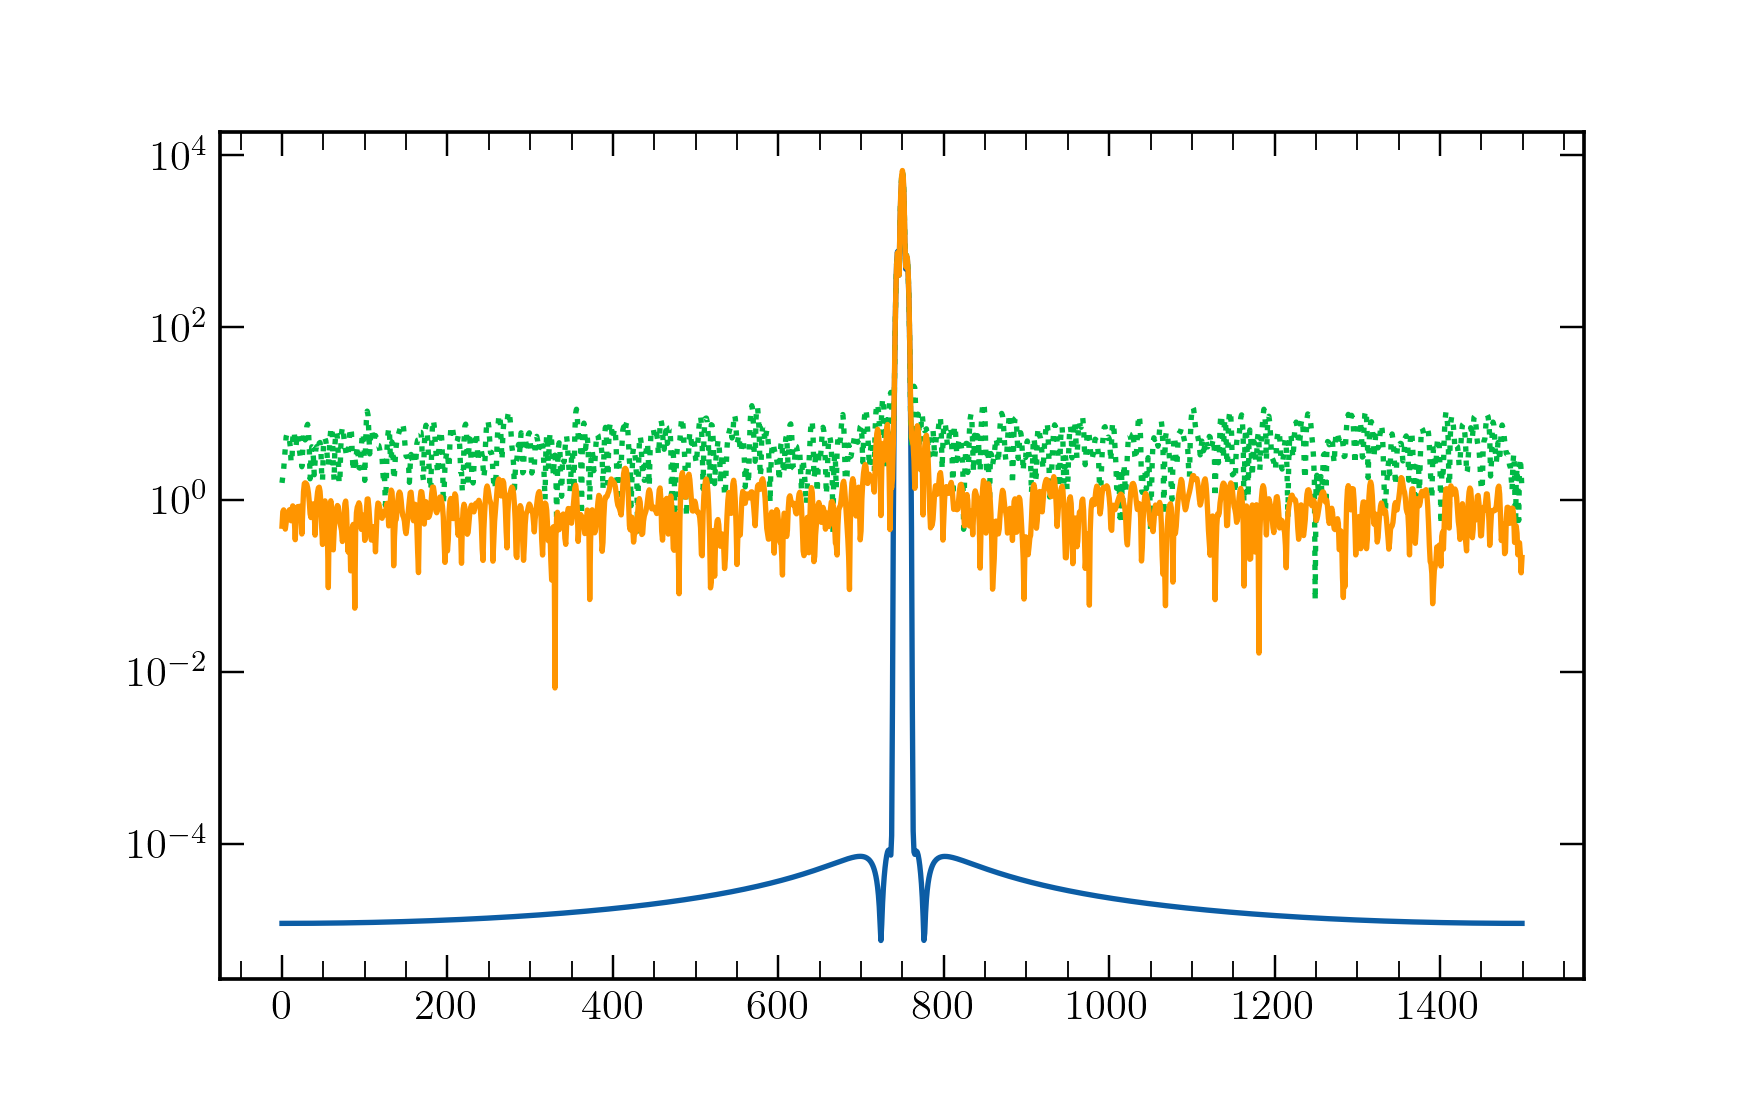

In [156]:
plt.figure()
plt.semilogy(delay_spectra(model_matrix[0, 1]))
plt.semilogy(delay_spectra(cal[0, 1]), ls=':')
plt.semilogy(delay_spectra(cal_fn[0, 1]))
plt.show()

<IPython.core.display.Javascript object>


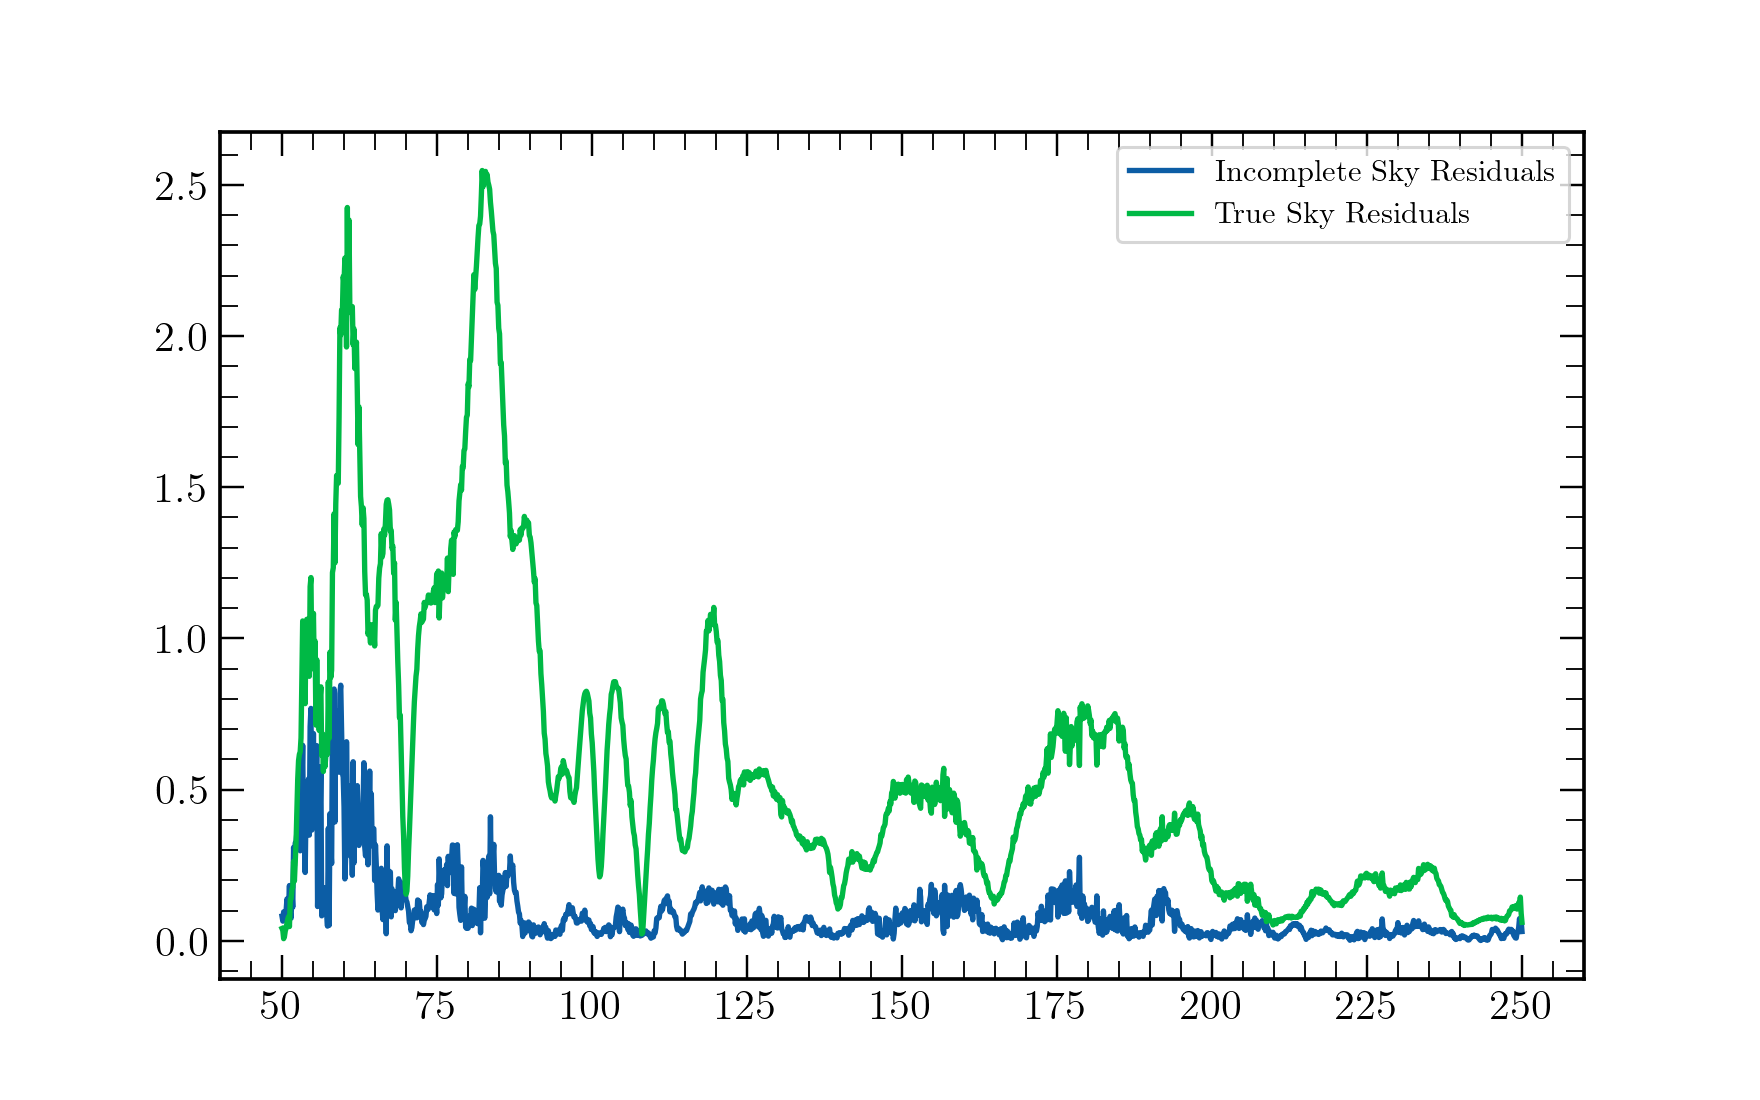

In [157]:
ant1, ant2 = 0, 9

plt.figure()
plt.plot(freqs / 1e6, np.abs(cal_fn[ant1, ant2] - nucal_model_matrix[ant1, ant2]), label='Incomplete Sky Residuals')
plt.plot(freqs / 1e6, np.abs(cal_fn[ant1, ant2] - true_model_matrix[ant1, ant2]), label='True Sky Residuals')
plt.legend()
plt.show()

<IPython.core.display.Javascript object>


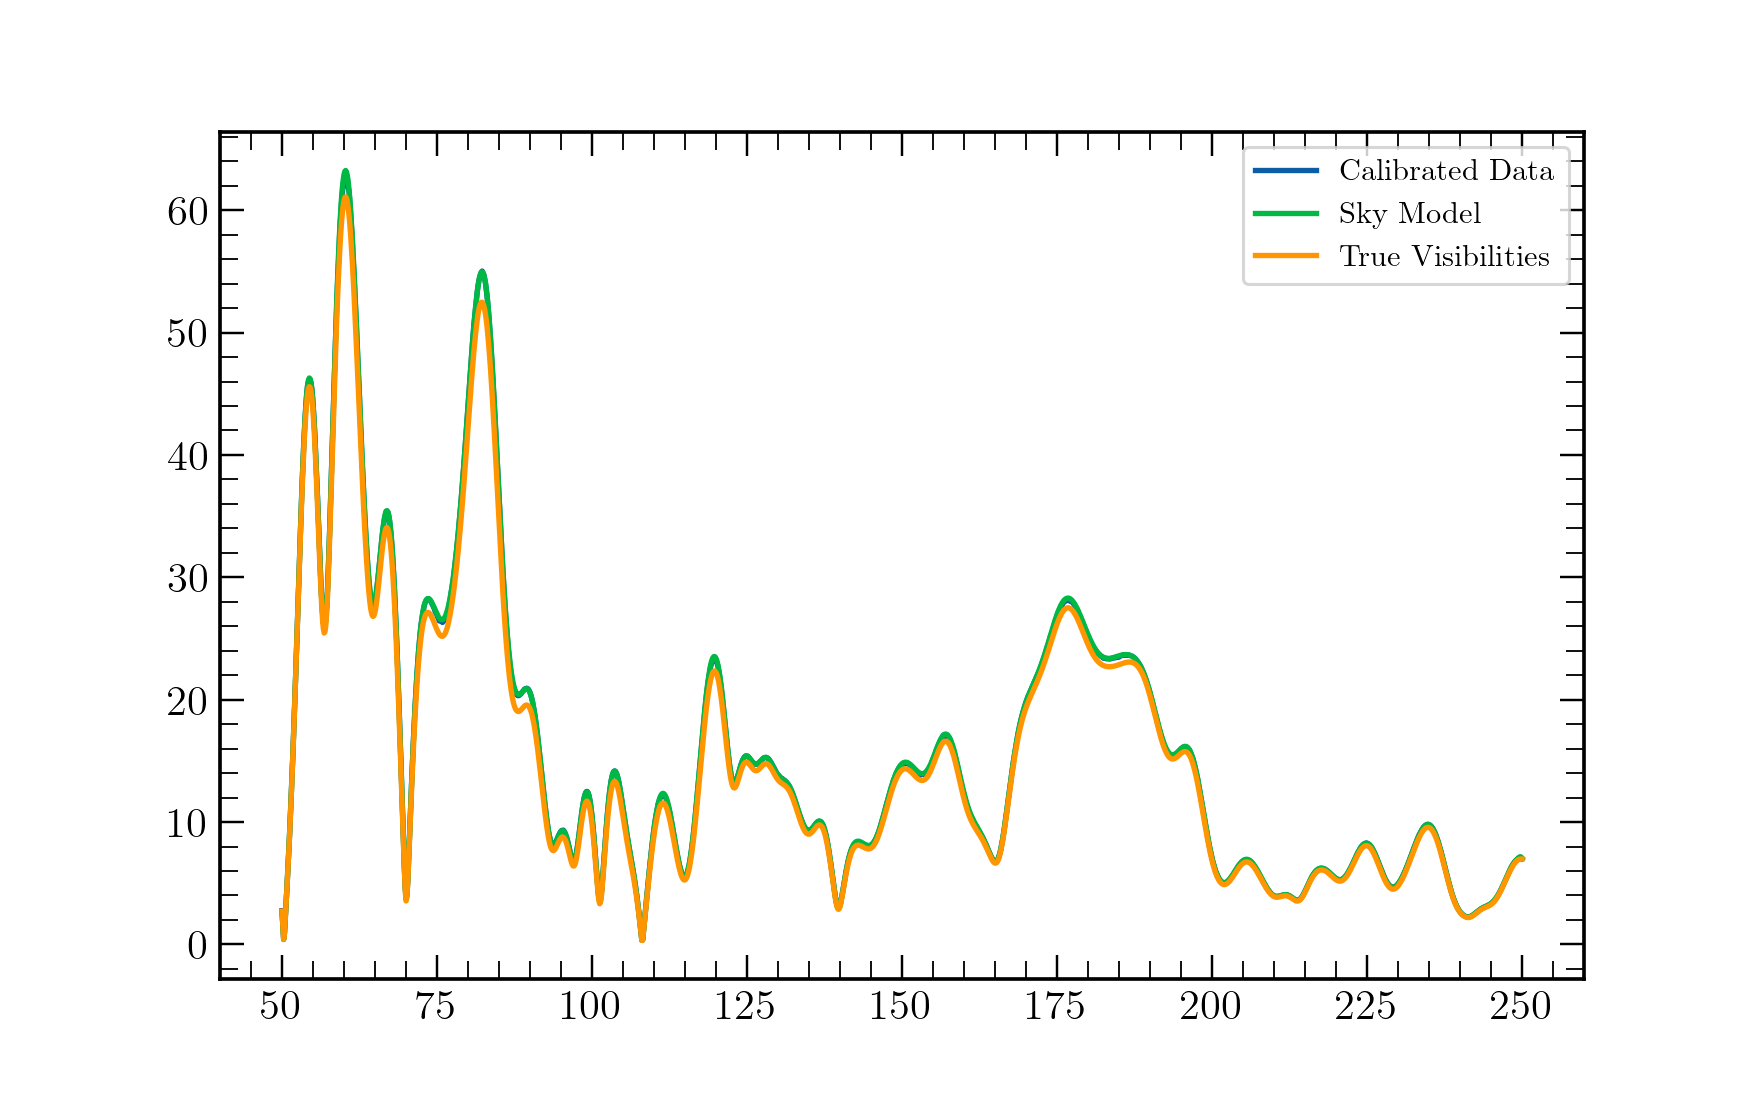

In [159]:
ant1, ant2 = 0, 9

plt.figure()
plt.plot(freqs / 1e6, np.abs(cal_fn[ant1, ant2]), label='Calibrated Data')
plt.plot(freqs / 1e6, np.abs(nucal_model_matrix[ant1, ant2]), label='Sky Model')
plt.plot(freqs / 1e6, np.abs(true_model_matrix[ant1, ant2]), label='True Visibilities')
plt.legend()
plt.show()

## Self-Cal Iterate

In [161]:
radial_reds = nucal.RadialRedundancy(antpos)
spatial_filters = nucal.compute_spatial_filters(radial_reds, freqs)
spectral_filters = nucal.compute_spectral_filters(freqs, 30e-9)[0].real
wgts = {k: np.ones_like(dc[k]).real for k in dc}


for i in range(15):
    print (i)
    # Fix Gains
    gains = {(i, "Jnn"): gstef_new[i][None, :] for i in range(gstef_new.shape[0])}
    dc = datacontainer.DataContainer({k + ('nn', ): np.copy(vis_dict[k])[None, :] for k in vis_dict})
    apply_cal.calibrate_in_place(dc, gains)

    # Fit Nucal Model to Calibrated Data
    nucal_model = nucal.fit_nucal_foreground_model(dc, wgts, radial_reds, spatial_filters, spectral_filters, tol=1e-9)

    data_matrix = np.zeros((nants, nants, nfreqs), dtype=complex)
    nucal_model_matrix = np.zeros((nants, nants, nfreqs), dtype=complex)

    nucal_model = datacontainer.DataContainer(nucal_model)
    
    wgts_array = np.zeros_like(model_matrix).real

    for n in range(Nants):
        for m in range(Nants):
            if n != m:
                if np.linalg.norm(antpos[m] - antpos[n]) < 70:
                    data_matrix[m, n] = vis_dict[(m, n)]
                    nucal_model_matrix[m, n] = nucal_model[radial_reds.get_redundant_group((m, n, 'nn'))[0]][0]
                    wgts_array[m, n] = 1
                    
    gstef_new, niter = run_stefcal(data_matrix, nucal_model_matrix, wgts_array, maxiter=1000, tol=1e-12, stepsize=0.5)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14


In [162]:
Gfn = gstef_new[:, None, :] * gstef_new[None, ...].conj()
cal_fn = data_matrix / Gfn

<IPython.core.display.Javascript object>


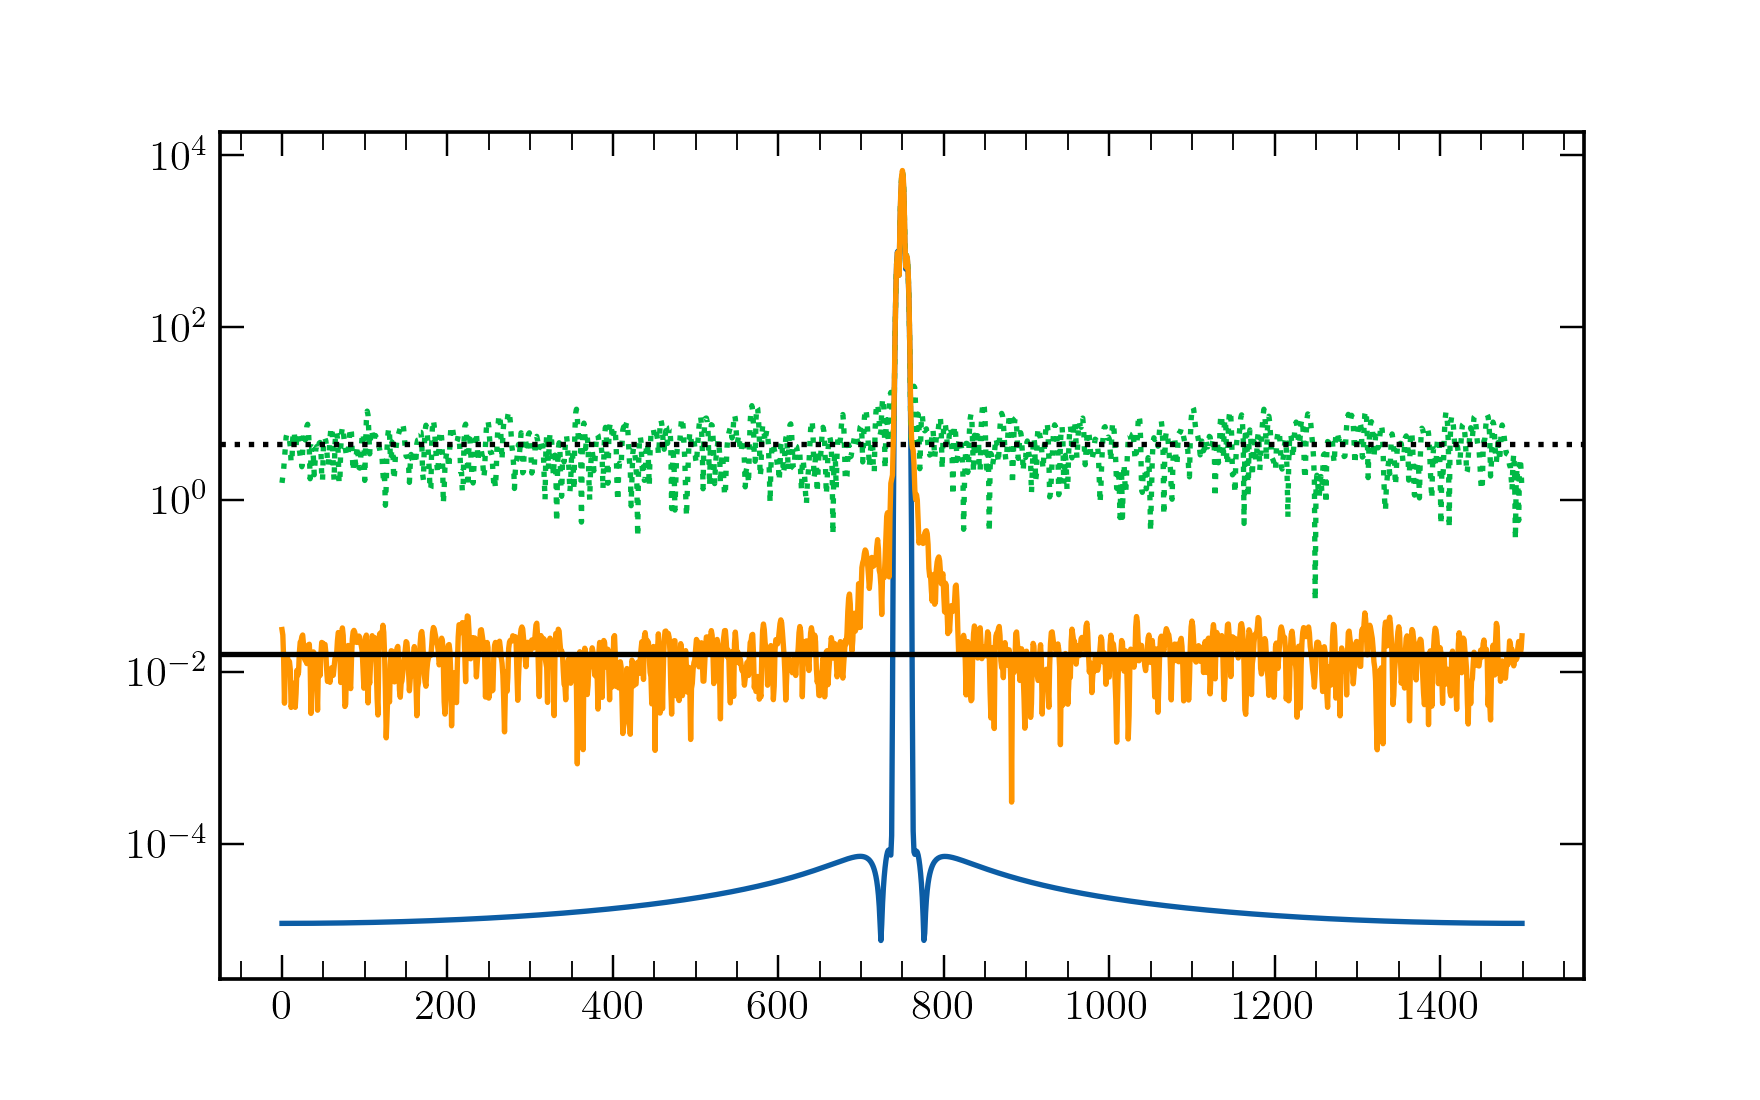

In [163]:
plt.figure()
plt.semilogy(delay_spectra(model_matrix[0, 1]))
plt.semilogy(delay_spectra(cal[0, 1]), ls=':')
plt.axhline(np.median(delay_spectra(cal[0, 1])), color='k', ls=':')
plt.semilogy(delay_spectra(cal_fn[0, 1]))
plt.axhline(np.median(delay_spectra(cal_fn[0, 1])), color='k')
plt.show()